# LangChain Agents - Financial Analysis with Gemini

Complete building production-ready agents with memory, middleware, and streaming

## Overview 
This notebook covers:  
- Short-term Memory: Persist conversation state with SQLite
- Built-in Middleware: Production partterns (summarization, limits, PII detection, todo tracking)
- Structured Output: Type-safe agent responses with Pydantic
- Streaming Modes: Real-time updates (messages, updates, values)

## Setup
Initialize model and tools for financial analysis

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain.agents import create_agent
from scripts import base_tools

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
system_prompt = "You are a financial analyst specializing in tech stocks." \
"Provide data-driven analysis with clear insights." \
"You have access to web_search tools and get_weather tools. "

## 1.Basic Agent
Create simple agent with tools but no memory

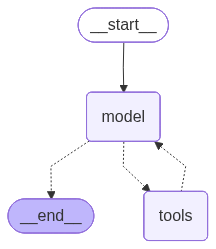

In [6]:
agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt
)
agent

In [8]:
query = "What is the apple's current stock price?"
response = agent.invoke({"messages":[HumanMessage(query)]})

In [9]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price?", additional_kwargs={}, response_metadata={}, id='52efc7db-f7cd-4d5c-a8f4-cf3239f06d1d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Apple stock price"}'}, '__gemini_function_call_thought_signatures__': {'fa0b05c1-26ea-47cd-bc12-53f343a4a347': 'CrUBAb4+9vtkZ4fFAhhYxXA0GOf6HEuogTdFtknvaB2idlo6mF6D+fK29atVVLXXPSFeLQEvSDO2F0vBzhUJkvIrT8z+uCh7z/IPELTIi0IZNyJw90ATQ1FaQHHEKniA/sTRlKBNDooL03boGMBXVqqz9fMJeeHYQgwlBChZPU137VzVoVRQpmq+sSNgnaSeqWL87vsc4Cg1/tjDX5UADVIfoFj56CSsGnTILmrXK9SguQ4Gn36FRw=='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c2cf8-6792-7b51-9975-256d5e885014-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'Apple stock price'}, 'id': 'fa0b05c1-26ea-47cd-bc12-53f343a4a347', 'type': 'tool_call'}], invalid_tool_calls=[], usage

In [10]:
query = "What is the apple's current stock price? and What is the lastest weather in London?"
response = agent.invoke({"messages":[HumanMessage(query)]})

In [11]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price? and What is the lastest weather in London?", additional_kwargs={}, response_metadata={}, id='fa7ac752-f5f6-4cc3-9328-50cbfbad69b4'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'c4589b1f-9dbc-412d-bf07-bcb58f629875': 'Cv8DAb4+9vv275RGwJHPB5e9AalcuLRu+MDIe4/TUo1Gd3EBeersFJivEB8LlwYNxqP54AYpHLETO8WBgeyx8XMbaYbJfJxfjiSdnD1UW76nNDlpZhGse2QdVvhhNJQdkjh96Os7QG2254ok6H5qhJI5IrON0bRS9h0wtYB89IUIAqQJONmjIc2yjMbiYtKytqjYq1ufLyG/WsQAh4AMxIJbVPZk1xkPHl9/22sedrejH8z5s5LDBNiBMc/EuAnaK/EyPvjqr0vxSupX169/29GBa3a7ELzOKxyARvlF3Q6Z9KCsbck7vR+hIkOoEA3rGIw3KqCC+M+oJC4keutK9ZnjlpHMfKV4Zpd2ms2DPrftXddKC7m+9Med+Qub31owSKvqzEuaMfkv/mKlLWoSdkGYQ2DLitB2YjzfQAyeZmdyXbrSIm9Hho/z+1+GWpaUygNgJkFNqpMavuvHa+se5UuM23t18h5peMbyEBYe2UBvI43H3fIJzM/U4xr/OAnuoa5HQezUE0D1V4/wtPuz706MJpNlE/CTRDwy7NRCCxkdq642LepHMiwRFdS6jMJ9X

In [12]:
print(response["messages"][-1].text)

Apple's current stock price is $280.70 as of December 4, 2025, 4:00 p.m. ET.

The latest weather in London is 6.1°C with light drizzle, and it feels like 2.3°C. The wind is from the ESE at 21.2 kph, and humidity is 93%. This information was last updated on 2026-02-05 08:45.


## 2. Short-term Memory with SQLite
Add conversation persistence using SQLite checkpointer. Agents remember previous turns within a session

In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("data/financial_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [14]:
agent_memory = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer
)

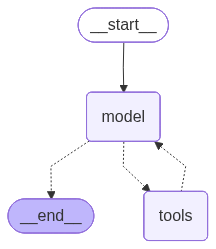

In [15]:
agent_memory

In [16]:
query

"What is the apple's current stock price? and What is the lastest weather in London?"

In [17]:
config = {"configurable": {"thread_id": "memory_session"}}
response = agent_memory.invoke({"messages":[query]}, config=config)

In [18]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price? and What is the lastest weather in London?", additional_kwargs={}, response_metadata={}, id='0974ae67-6bf0-4ba8-a0a2-82bd184f7885'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'68ccbcf7-8c60-44b0-9abf-70da0c3d897b': 'CskDAb4+9vu1Mt1zdtfb8qjMEj+vovj8xyo4eD9RUA+9T7O1VoO03Vc3zkLn+x80AClOCMEjfVwztVe5kZ7Fm13a9KApwBysU3q+cHcbRrCOOqQaZoq0KdGjx4rhq0nxhG1RNknVYOtGlG/DNqEx8nBORivWuyYYnA/sLCzNFb9nAtcdTchKQXppwLNSFFTvFFLvsjeugV1zbustVV9gKWIK1qbEqUGbwnvHFza/u+ZL3ppktc9r0VywpuB2lmuA89lnewEpzqaUs+cO4sx3GA3Zzf4T4gWY9YzmLGGbkfZxBQFlBaeLdlj/96E/ECx7BphDBThWAEVJBYLPzAdSG33ClgIYP2rCdV5W3WaLo1EEQAcoD9m/0qFLJKxhL9Tc3+bJUcf0kyv06PmXMJgi/SHVVsSZ/xvsP1/xdlIarHmjl2bRm5fcs7Cz7LdviK2wAG+zdyL64hs9+3pIX3qj6r+NKLQ6H0zIlUXVDB94171olJGa4w4ifGAjWWI+IA/bzNcxpEaB1uOItfMn6hYEOXmYsBpytIFNoGlCqYuQaAfddG7yEMUMUrZAIIV5Z3Ik+

In [19]:
response = agent_memory.invoke({"messages":["What is the latest US stock news"]}, config=config)

In [20]:
response

{'messages': [HumanMessage(content="What is the apple's current stock price? and What is the lastest weather in London?", additional_kwargs={}, response_metadata={}, id='0974ae67-6bf0-4ba8-a0a2-82bd184f7885'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'68ccbcf7-8c60-44b0-9abf-70da0c3d897b': 'CskDAb4+9vu1Mt1zdtfb8qjMEj+vovj8xyo4eD9RUA+9T7O1VoO03Vc3zkLn+x80AClOCMEjfVwztVe5kZ7Fm13a9KApwBysU3q+cHcbRrCOOqQaZoq0KdGjx4rhq0nxhG1RNknVYOtGlG/DNqEx8nBORivWuyYYnA/sLCzNFb9nAtcdTchKQXppwLNSFFTvFFLvsjeugV1zbustVV9gKWIK1qbEqUGbwnvHFza/u+ZL3ppktc9r0VywpuB2lmuA89lnewEpzqaUs+cO4sx3GA3Zzf4T4gWY9YzmLGGbkfZxBQFlBaeLdlj/96E/ECx7BphDBThWAEVJBYLPzAdSG33ClgIYP2rCdV5W3WaLo1EEQAcoD9m/0qFLJKxhL9Tc3+bJUcf0kyv06PmXMJgi/SHVVsSZ/xvsP1/xdlIarHmjl2bRm5fcs7Cz7LdviK2wAG+zdyL64hs9+3pIX3qj6r+NKLQ6H0zIlUXVDB94171olJGa4w4ifGAjWWI+IA/bzNcxpEaB1uOItfMn6hYEOXmYsBpytIFNoGlCqYuQaAfddG7yEMUMUrZAIIV5Z3Ik+

## 3. Built-in Middleware: Summarization
Automatically summarize old messages when history grows too long
- Usecase: Long conversations that exceed context window

In [9]:
from langchain.agents.middleware import SummarizationMiddleware

In [22]:
agent_summary = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[SummarizationMiddleware(
        model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite"),
        trigger=[("messages", 10)],
        keep=("messages", 5)
    )]
)

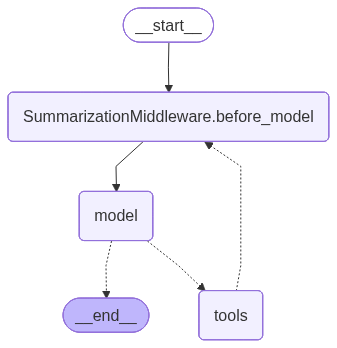

In [23]:
agent_summary

In [ ]:
response = agent_summary.invoke({"messages": ["Tài sản của Elon Musk là bao nhiêu?"]}, config=config)

In [28]:
response

{'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\n## SESSION INTENT\nThe user wants to know the current stock price of Apple and the latest weather in London.\n\n## SUMMARY\nThe user requested the current stock price of Apple and the latest weather in London.\nI performed a web search for "Apple stock price" and used the `get_weather` tool for "London".\nThe web search results provided two potential stock prices, with the most recent being $280.70 as of December 4, 2025, 4:00 p.m. ET.\nThe `get_weather` tool returned that the latest weather in London, as of February 5, 2026, 09:30 GMT, is 6°C with light drizzle.\n\n## ARTIFACTS\nNone\n\n## NEXT STEPS\nNone', additional_kwargs={'lc_source': 'summarization'}, response_metadata={}, id='9621b7ee-2714-43f8-9815-10d03bea997f'),
  HumanMessage(content='What is the latest US stock news', additional_kwargs={}, response_metadata={}, id='bf1d692a-3bbc-49c9-b795-8bcdc1a5f148'),
  AIMessage(content='', additional

## 4. Middleware: Model and Tool Call Limit
Limit the number of model calls per request to prevent runaway costs  
Exit Behaviors: "end" stop or "continue" proceed without model

In [5]:
from langchain.agents.middleware import ModelCallLimitMiddleware, ToolCallLimitMiddleware, ModelFallbackMiddleware

In [11]:
agent_limit = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    system_prompt=system_prompt,
    checkpointer=checkpointer,
    middleware=[
        SummarizationMiddleware(
            model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite"),
            trigger=[("messages", 15)],
            keep=("messages", 5)
        ), 
        ModelCallLimitMiddleware(run_limit=2, exit_behavior="end"),
        ToolCallLimitMiddleware(run_limit=2, exit_behavior="continue"),
        ModelFallbackMiddleware(ChatGoogleGenerativeAI(model="gemini-3-pro-preview"))
    ]
)

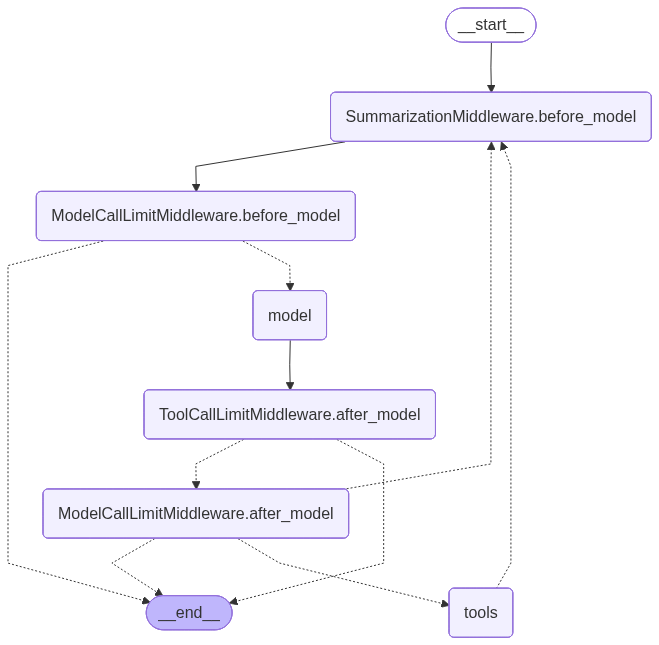

In [12]:
agent_limit

In [16]:
config = {"configurable": {"thread_id": "limit_session"}}

In [19]:
response = agent_limit.invoke({"messages": ["What is the total distance between earth and moon. What is the lastest news on Trump? What is the lastest weather of London"]}, config=config)

In [20]:
response

{'messages': [HumanMessage(content='What is the total distance between earth and moon. What is the lastest news on Trump? What is the lastest weather of London', additional_kwargs={}, response_metadata={}, id='8755ad27-b3ca-4116-8db1-dd505a513cde'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "London"}'}, '__gemini_function_call_thought_signatures__': {'7757394f-aa5d-4816-931a-2d319681db6b': 'CpUFAb4+9vvZtK25xRvaHGMkCIKPZ+d9Tp5OBiL0Y8T39nnD+j7QpqJ/CWhNo6AHC6nQ4EPpFK+jloRdP2GXxpF3fWcW8cAoT2SguHsQjBCsH7YcztnQEmUCjqaLbPU+U79CQVTnHBUfFAdku5VjVpEdYwOXaOvUB9SOheEgmCHApnZ5MKYvhJYfhBkQLYlr90+MxVUCfY5rMFKNHXFK1OsV5PMRnV9g8wYuC1WG1YZEjb15stQVO7g/2iLm7NbSQa2IMhmKrNdIwoEasHfhUYMIOOJZkGGQ/6n0ayNg1IvN88Ngn2sb4AmG3SApjgqfshbQUsTusTA/QidTQnnBfaUlcWauY1ziH4UHB5TGRbEtgL+FvyTkSaf9QF6rQTfvMr+XgM3aCyKyskBSsHlCdbeAu/civRmaqh1DJPl59CIMOLWIlVf+h0vM6xpD5FKh9MQOo3ScARHyuXZ0ahwDu+haHl1ltkGt2ciD0eM7gTmtGYPZo+KhwtyjNIWK+eIZexiKPSLo5dJoAnVP0ftadY43C

## 5. Middleware: Guardrails and PII Detection
Automatically detect and redact/mask personality identify information  
Stratergies: "redact"(remove), "mask"(replace with ***), "block"(prevent request) 